This script plots the effect of Mecp2 deletion on trans AB ratio along the radial axis and separated by A and B loci.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import sys

print(f'PID number is {os.getpid()}')

sys.path.append(r'C:\Users\cosmosyw\Documents\Softwares')
    
analysis_folder = r'C:\Users\cosmosyw\Documents\Research\Mecp2_v2\analysis\figures\transAB'
    
figure_folder = os.path.join(analysis_folder, 'figures')
if not os.path.exists(figure_folder):
    os.mkdir(figure_folder)

mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=10.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=8.)
mpl.rc('axes', titlesize=9.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='pdf')

mpl.rc('xtick', labelsize=7.)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=0.5)

mpl.rc('ytick', labelsize=7.)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=0.5)

mpl.rcParams['pdf.fonttype'] = 42

PID number is 37868


# Load AB ratio and refgen file

In [4]:
folder_AB_ratio = r'C:\Users\cosmosyw\Documents\Research\Mecp2_v2\analysis\figures\transAB\AB_ratio_subclass'
transABratio_ensemble_filename = os.path.join(folder_AB_ratio, 
                                              f'transABRatio_thresh0_r0.5_bysubclass.pkl')

transABratio = pickle.load(open(transABratio_ensemble_filename, 'rb'))

In [5]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].astype(str)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5


# Filter

In [6]:
# only calculate the cells with more than 600 points (similar as the radial positions)
transABratio_filtered = {}

for key, ratio_list in transABratio.items():
    transABratio_filtered[key] = []
    cell_counts = 0
    for cell_ratio in ratio_list:
        total_pts = 0 # used to calculate the number of valid points in this cell
        for chrom, chr_list in cell_ratio.items():
            for chr_ratio in chr_list:
                total_pts += len(np.where(~np.isnan(chr_ratio))[0])
        if (total_pts>=600):
            transABratio_filtered[key].append(cell_ratio)
            cell_counts += 1
    print(f'{key} has {cell_counts} cells')

L6b_WT has 265 cells
L6b_KO has 361 cells
L6 CT_WT has 2025 cells
L6 CT_KO has 2948 cells
L6 IT_WT has 911 cells
L6 IT_KO has 1415 cells
L5 IT_WT has 915 cells
L5 IT_KO has 1403 cells
L4/5 IT_WT has 526 cells
L4/5 IT_KO has 923 cells
L2/3 IT_WT has 928 cells
L2/3 IT_KO has 1460 cells
L5/6 NP_WT has 243 cells
L5/6 NP_KO has 403 cells
L5 ET_WT has 341 cells
L5 ET_KO has 538 cells
Sncg_WT has 54 cells
Sncg_KO has 75 cells
Sst_WT has 330 cells
Sst_KO has 396 cells
Vip_WT has 146 cells
Vip_KO has 151 cells
Pvalb_WT has 461 cells
Pvalb_KO has 582 cells
Lamp5_WT has 119 cells
Lamp5_KO has 132 cells
Astro_WT has 608 cells
Astro_KO has 937 cells
Endo-PVM_WT has 758 cells
Endo-PVM_KO has 742 cells
SMC-VLMC_WT has 68 cells
SMC-VLMC_KO has 108 cells
Peri_WT has 247 cells
Peri_KO has 364 cells
Micro_WT has 213 cells
Micro_KO has 236 cells
Oligo_WT has 1544 cells
Oligo_KO has 2376 cells
OPC_WT has 213 cells
OPC_KO has 260 cells


# Calculate AB ratio changes

In [7]:
from scipy.stats import mannwhitneyu

In [8]:
subclasses = []
for key in transABratio_filtered.keys():
    subcls = key.split('_')[0]
    if subcls not in subclasses:
        subclasses.append(subcls)

In [9]:
AB_ratio_dfs = []

for sel_cls in subclasses:
    
    dict_AB_ratio = {}
    dict_AB_ratio['loci_name'] = []
    dict_AB_ratio['trans_AB_diff_KO_over_WT'] = []
    dict_AB_ratio['trans_AB_WT'] = []
    dict_AB_ratio['trans_AB_KO'] = []
    
    for chrom, df_chr in tqdm(df_refgen.groupby('chr')): 
        if chrom!='Y':
            _df_chr = df_chr.copy()
            _df_chr = _df_chr.sort_values('chr_order')
            region_names = _df_chr['loci_name'].values

            dict_AB_ratio['loci_name'] = dict_AB_ratio['loci_name'] + list(region_names)

            wt_chr = []
            for dict_AB in transABratio_filtered[sel_cls+'_WT']:
                if chrom in dict_AB.keys():
                    AB_ratio_list = dict_AB[chrom]
                    for AB_ratio in AB_ratio_list:
                        wt_chr.append(AB_ratio)
            ko_chr = []
            for dict_AB in transABratio_filtered[sel_cls+'_KO']:
                if chrom in dict_AB.keys():
                    AB_ratio_list = dict_AB[chrom]
                    for AB_ratio in AB_ratio_list:
                        ko_chr.append(AB_ratio)

            wt_chr = np.array(wt_chr)
            ko_chr = np.array(ko_chr)
            _total_pts = wt_chr.shape[1]
            _total_wt_cells = wt_chr.shape[0]

            exp_change =  np.nanmean(ko_chr, axis=0) - np.nanmean(wt_chr, axis=0)
            
            dict_AB_ratio['trans_AB_WT'] = dict_AB_ratio['trans_AB_WT'] + list(np.nanmean(wt_chr, axis=0))
            dict_AB_ratio['trans_AB_KO'] = dict_AB_ratio['trans_AB_KO'] + list(np.nanmean(ko_chr, axis=0))
            dict_AB_ratio['trans_AB_diff_KO_over_WT'] = dict_AB_ratio['trans_AB_diff_KO_over_WT'] + list(exp_change)
    df = pd.DataFrame(dict_AB_ratio)
    df['subclass'] = sel_cls
    AB_ratio_dfs.append(df)

df_AB_ratio = pd.concat(AB_ratio_dfs, ignore_index=True)
df_AB_ratio.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 826.73it/s]


,loci_name,trans_AB_diff_KO_over_WT,trans_AB_WT,trans_AB_KO,subclass
0,chr1_3742742_3759944,-0.139859,-0.165286,-0.305146,L6b
1,chr1_6245958_6258969,0.126057,-0.297860,-0.171802,L6b
2,chr1_8740008_8759916,-0.174819,-0.181237,-0.356057,L6b
3,chr1_9627926_9637875,0.004690,-0.107173,-0.102483,L6b
4,chr1_9799472_9811359,0.045375,-0.208582,-0.163208,L6b


# Load RP

In [17]:
df_rp = pd.read_csv(r'E:\DNA_analysis\Postanalysis_MeCP2\radial_position\all_subclass_rp_600pts_final.csv',
                   index_col=0)
### split the points into 5th percentile for RP
def get_upper_bound(all_values, bin_size=5):
    percentiles = np.arange(0,100, bin_size)
    percentiles = percentiles + bin_size
    upper_bound = []
    for p in percentiles:
        upper_bound.append(np.percentile(all_values, p))
    upper_bound = np.array(upper_bound)
    return upper_bound

analysis_dfs = []
for subcls in sel_subclasses:
    df = df_rp[df_rp['subclass']==subcls].copy()
    
    rp_upper_bound = get_upper_bound(df['WT_norm_RP'].values)
    
    df['RP_interval'] = df['WT_norm_RP'].apply(lambda x: np.argmax(rp_upper_bound>=x))
    
    analysis_dfs.append(df)

df_rp = pd.concat(analysis_dfs, ignore_index=True)
df_rp.head()

,loci_name,AB,WT_norm_RP,KO_norm_RP,WT_distance_to_center,KO_distance_to_center,subclass,RP_interval
0,chr1_3742742_3759944,B,0.837700,0.810326,3.892021,3.877548,L2/3 IT,17
1,chr1_6245958_6258969,B,0.840414,0.822126,3.915844,3.904488,L2/3 IT,17
2,chr1_8740008_8759916,B,0.830338,0.794746,3.968803,3.764145,L2/3 IT,16
3,chr1_9627926_9637875,B,0.824011,0.814497,3.869235,3.852427,L2/3 IT,15
4,chr1_9799472_9811359,B,0.816209,0.805244,3.888839,3.878895,L2/3 IT,15


In [18]:
df_analysis = df_rp.merge(df_AB_ratio, left_on=['loci_name','subclass'], right_on=['loci_name','subclass'])
df_analysis

,loci_name,AB,WT_norm_RP,KO_norm_RP,WT_distance_to_center,KO_distance_to_center,subclass,RP_interval,trans_AB_diff_KO_over_WT,trans_AB_WT,trans_AB_KO
0,chr1_3742742_3759944,B,0.837700,0.810326,3.892021,3.877548,L2/3 IT,17,0.106801,-0.428595,-0.321794
1,chr1_6245958_6258969,B,0.840414,0.822126,3.915844,3.904488,L2/3 IT,17,0.128898,-0.365664,-0.236767
2,chr1_8740008_8759916,B,0.830338,0.794746,3.968803,3.764145,L2/3 IT,16,0.277182,-0.445686,-0.168504
3,chr1_9627926_9637875,B,0.824011,0.814497,3.869235,3.852427,L2/3 IT,15,0.088338,-0.361652,-0.273315
4,chr1_9799472_9811359,B,0.816209,0.805244,3.888839,3.878895,L2/3 IT,15,0.306751,-0.436787,-0.130036
...,...,...,...,...,...,...,...,...,...,...,...
19805,chrX_163750534_163758706,A,0.716245,0.740933,2.847415,2.832142,Endo-PVM,12,-0.082834,0.296228,0.213394
19806,chrX_166247682_166259932,A,0.745849,0.747319,2.967475,2.878308,Endo-PVM,14,-0.108180,0.225296,0.117115
19807,chrX_167157164_167167452,A,0.708879,0.672011,2.882917,2.697699,Endo-PVM,12,0.115821,0.363115,0.478936
19808,chrX_168746045_168757590,A,0.761169,0.755313,2.950083,3.011793,Endo-PVM,15,-0.116925,0.187833,0.070908


# Plot

In [19]:
sel_subclasses = ['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 ET','L5/6 NP', 'L6 CT','Astro', 'Oligo', 'Endo-PVM']

color_map = {'L2/3 IT':'navy', 'L4/5 IT':'mediumblue', 'L5 IT':'slateblue', 'L6 IT':'dodgerblue','L5 ET':'steelblue',
             'L5/6 NP':'lightsteelblue' , 'L6 CT':'cyan',
             'Pvalb':'darkgreen', 'Sst':'green',
            'Astro':'darkred', 'Oligo':'red', 'Endo-PVM':'saddlebrown'}

C:\Users\cosmosyw\AppData\Local\Temp\ipykernel_37868\833835595.py:36: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(figure_name)
meta NOT subset; don't know how to subset; dropped
C:\Users\cosmosyw\anaconda3\envs\merlin_postanalysis\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


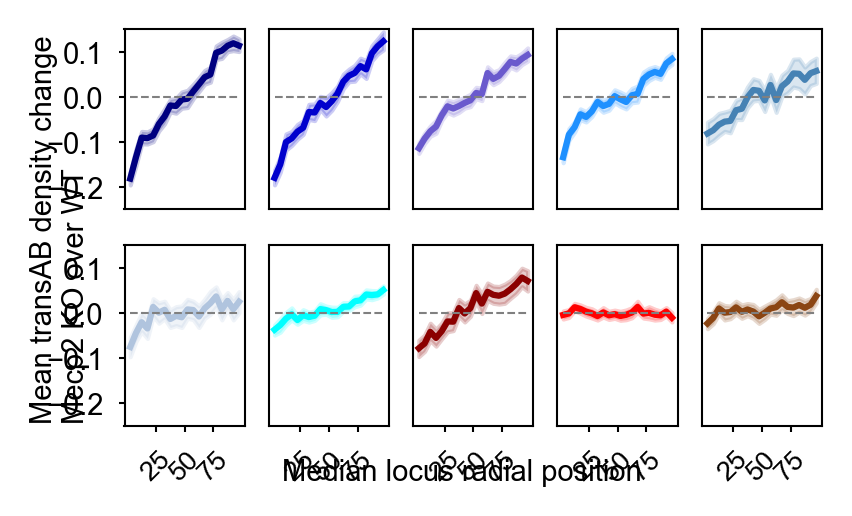

In [30]:
# the effect of Mecp2 deletion on trans AB ratio changes - Fig. 6D
from matplotlib.gridspec import GridSpec
spec = GridSpec(nrows=2, ncols=5)

fig = plt.figure(figsize=(3.0,1.75), dpi=300)

for i, subcls in enumerate(sel_subclasses):
    ax = fig.add_subplot(spec[i//5,i%5])
    
    df_plot = df_analysis[df_analysis['subclass']==subcls].copy()
    color = color_map[subcls]
    
    sns.lineplot(data=df_plot, x='RP_interval', y='trans_AB_diff_KO_over_WT', ax=ax, color=color)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(-1, 20)
    ax.set_ylim(-0.25, 0.15)
    ax.plot([0,19],[0,0], color='gray', linewidth=0.5, linestyle='--')
    
    if i==0 or i==5:
        ax.set_yticks([-0.2,-0.1,0.0,0.1], fontsize=6.5)
    else:
        ax.set_yticks([])
        
    if i<5:
        ax.set_xticks([])
    else:
        ax.set_xticks([4.5,9.5,14.5],[25,50,75], fontsize=6.5)
    ax.tick_params(axis='both', length=1.5)
    ax.tick_params(axis='x', rotation=45)
    
fig.supxlabel('Median locus radial position', fontsize=7)
fig.supylabel('Mean transAB density change\nMecp2 KO over WT', fontsize=7)

figure_name = 'transAB change by radial position.pdf'
plt.savefig(figure_name)

plt.show()

In [24]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

pvals = []
for i, subcls in enumerate(sel_subclasses):
    df_plot = df_analysis[df_analysis['subclass']==subcls].copy()
    df_plot = df_plot[df_plot['AB']!='unassigned'].copy()
    stats, p = ttest_ind(df_plot[df_plot.AB=='A']['trans_AB_diff_KO_over_WT'],
                           df_plot[df_plot.AB=='B']['trans_AB_diff_KO_over_WT'], equal_var=False)
    pvals.append(p)
reject, adj_p, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
adj_p

array([2.07223461e-083, 3.21731607e-103, 2.76682908e-094, 1.56852488e-046,
       1.16886391e-019, 1.66203132e-002, 1.68754503e-013, 5.73665877e-031,
       1.00000000e+000, 2.70579318e-003])

C:\Users\cosmosyw\AppData\Local\Temp\ipykernel_37868\2593994850.py:51: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(figure_name)
meta NOT subset; don't know how to subset; dropped
C:\Users\cosmosyw\anaconda3\envs\merlin_postanalysis\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


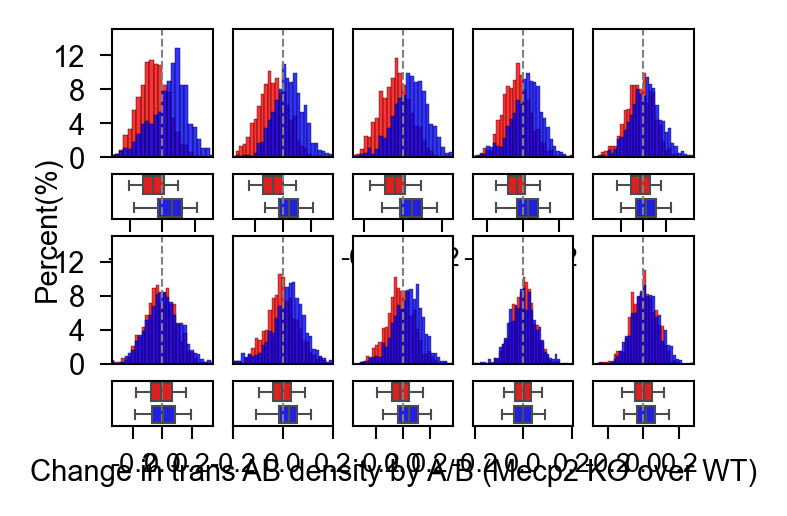

In [34]:
# the effect of Mecp2 deletion on trans AB density ratio for A and B loci, Fig. 6E
spec = GridSpec(nrows=4, ncols=5, height_ratios=[1,0.35, 1, 0.35])

fig = plt.figure(figsize=(2.5,1.75), dpi=300)

for i, subcls in enumerate(sel_subclasses):
    if i<5:
        row_index = 0
    else:
        row_index = 2
    ax = fig.add_subplot(spec[row_index,i%5])
    
    df_plot = df_analysis[df_analysis['subclass']==subcls].copy()
    df_plot = df_plot[df_plot['AB']!='unassigned'].copy()
    color = color_map[subcls]
    bound = max(np.percentile(df_plot['trans_AB_diff_KO_over_WT'].values, 1), np.percentile(df_plot['trans_AB_diff_KO_over_WT'].values, 99.9))
    ax.set_ylim(0,15)
    ax.set_xlim(-bound,bound)
    
    sns.histplot(data=df_plot, x='trans_AB_diff_KO_over_WT', hue='AB', ax=ax, stat='percent', common_norm=False,
                 palette={'A':'red', 'B':'blue'}, legend=False, alpha=0.8)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
    if i==0 or i==5:
        ax.set_yticks([0,4,8,12])
    else:
        ax.set_yticks([])
    
    ax.set_xticks([])
    
    ax.plot([0,0], [0,15], color='gray', linewidth=0.5, linestyle='--')
    
    ax2 = fig.add_subplot(spec[row_index+1,i%5])
    sns.boxplot(data=df_plot, x='trans_AB_diff_KO_over_WT', y='AB', ax=ax2, fliersize=0, linewidth=0.5,order = ['A','B'],
                 palette={'A':'red', 'B':'blue'}, whis=[5, 95])
    
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_ylabel(None)
    ax2.set_xlabel(None)
    ax2.set_xlim(-bound,bound)
    tick_pos = 0.1 if bound<0.15 else 0.2
    ax2.set_xticks([-tick_pos,0,tick_pos],[-tick_pos,0.0,tick_pos],fontsize=6.5)
    ax2.plot([0,0],[-0.5,1.5], linewidth=0.5, color='gray', linestyle='--')
    
fig.supxlabel('Change in trans AB density by A/B (Mecp2 KO over WT)', fontsize=7)
fig.supylabel('Percent(%)', fontsize=7)

figure_name = 'AB transAB_ratio_change.pdf'
plt.savefig(figure_name)

plt.show()